In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pathlib

fLO = 1575.42e6
fs = 24.576e6
Nfft = 1024
keep = 4
decim = int(0.1 * fs / (Nfft * keep))
T = keep * Nfft * decim / fs
fsky = fLO + np.fft.fftshift(np.fft.fftfreq(Nfft, 1/fs))

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
phase_cal = np.exp(-1j*np.array([-0.59549797,  1.2467982 ], dtype='float32'))*(-1j)
amplitude_cal = np.array([ 83852.48,  82903.98,  89799.99, 115325.31], dtype='float32')*2

In [3]:
def load(f):
    f = str(f)
    self = np.array([np.fromfile(f, dtype = 'float32'),
                     np.fromfile(str(f).replace('_0xx', '_0yy'), dtype = 'float32'),
                     np.fromfile(str(f).replace('_0xx', '_1xx'), dtype = 'float32'),
                     np.fromfile(str(f).replace('_0xx', '_1yy'), dtype = 'float32')])
    l = np.min([a.size for a in self])
    self = np.array([a[:l] for a in self])
    self = self[:self.size//(4*Nfft)*4*Nfft].reshape((4,-1,Nfft))
    cross = np.array([np.fromfile(str(f).replace('_0xx', '_0xy'), dtype = 'complex64'),
                     np.fromfile(str(f).replace('_0xx', '_1xy'), dtype = 'complex64')])
    l = np.min([a.size for a in cross])
    cross = np.array([a[:l] for a in cross])
    cross = cross[:cross.size//(2*Nfft)*2*Nfft].reshape((2,-1,Nfft))

    sat = f.split('/')[-1].split('_')[0]
    tstamps = np.datetime64(f.split('/')[-1].split('_')[1]) + (np.arange(self.shape[1]) * T * 1e9) * np.timedelta64(1,'ns')
    return self, cross, sat, tstamps

In [4]:
paths = pathlib.Path('/home/destevez/polarimetry/observations-2020-10-24/').glob('*_0xx')
data = [load(p) for p in list(paths)]
data.sort(key = lambda x: x[3][0])

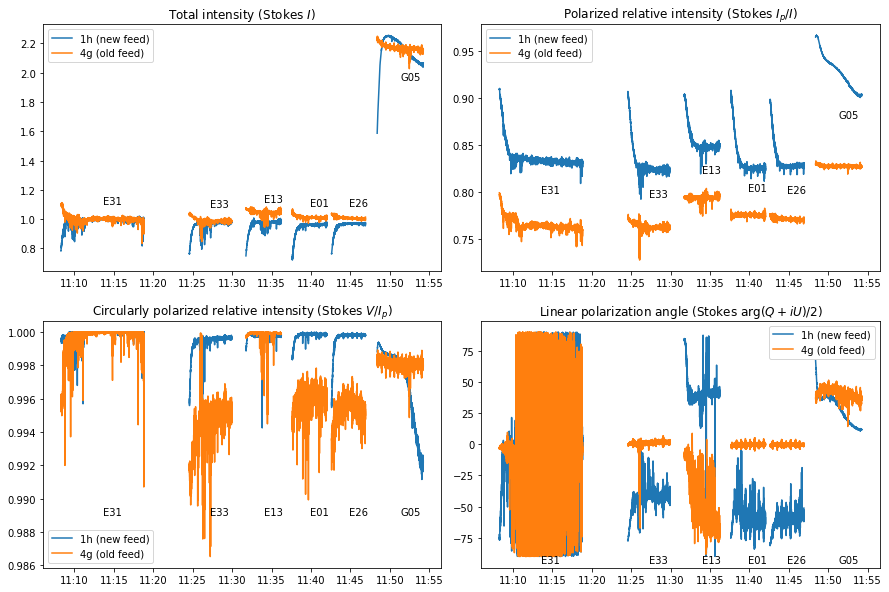

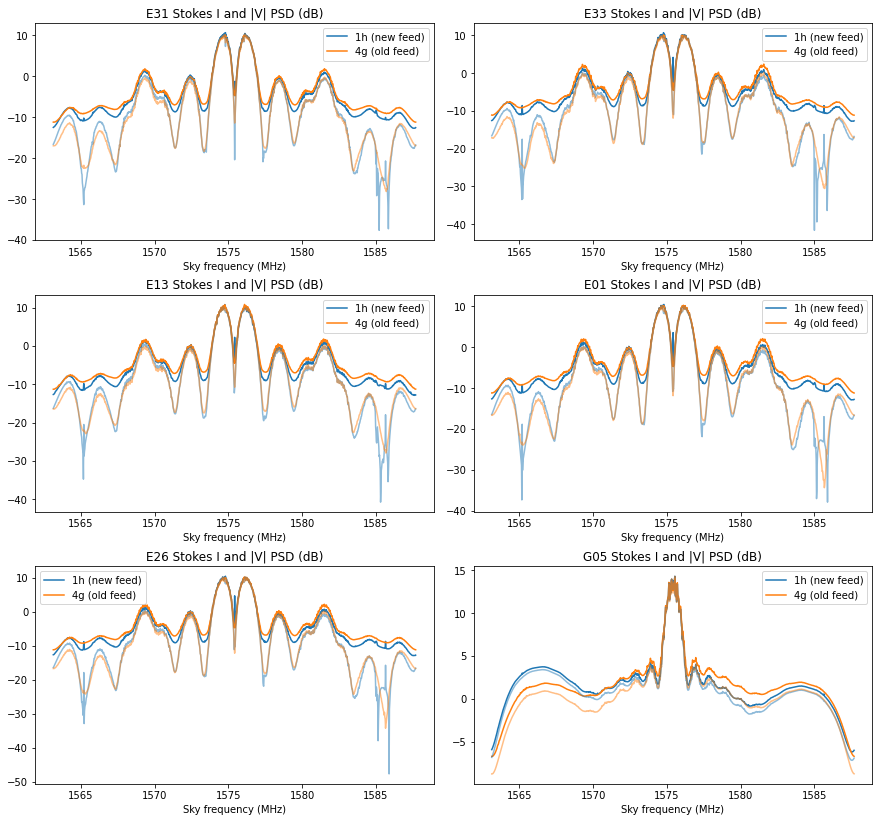

In [5]:
fig, axs = plt.subplots(2,2, figsize = (15,10), facecolor = 'w')
fig_f, axs_f = plt.subplots(3,2, figsize = (15,14), facecolor = 'w')
axs_f = axs_f.ravel()
axs = axs.ravel()
cross_amplitude_cal = np.sqrt(np.array([amplitude_cal[0]*amplitude_cal[1],
                                       amplitude_cal[2] * amplitude_cal[3]]))
time_fmt = mdates.DateFormatter('%H:%M')
for dn,d in enumerate(data):
    l = min(d[0].shape[1], d[1].shape[1])
    I = np.array([[1,1,0,0],[0,0,1,1]]) @ (np.average(d[0][:,:l], axis = 2)/amplitude_cal[:,np.newaxis])
    I_f = np.array([[1,1,0,0],[0,0,1,1]]) @ (np.average(d[0], axis = 1)/amplitude_cal[:,np.newaxis])
    axs_f[dn].plot(fsky*1e-6, 10*np.log10(I_f.T))
    axs_f[dn].set_title(f'{d[2]} Stokes I and |V| PSD (dB)')
    Q = np.array([[1,-1,0,0],[0,0,1,-1]]) @ (np.average(d[0][:,:l], axis = 2)/amplitude_cal[:,np.newaxis])
    UV = np.average(d[1][:,:l], axis = 2)*phase_cal[:,np.newaxis]/cross_amplitude_cal[:,np.newaxis]
    UV_f = np.average(d[1], axis = 1)*phase_cal[:,np.newaxis]/cross_amplitude_cal[:,np.newaxis]
    U = 2*np.real(UV)
    V = -2*np.imag(UV)
    V_f = -2*np.imag(UV_f)
    axs_f[dn].set_prop_cycle(None)
    axs_f[dn].plot(fsky*1e-6, 10*np.log10(np.abs(V_f).T), alpha = 0.5)
    Ip = np.sqrt(Q**2 + U**2 + V**2)
    theta = np.angle(Q + 1j*U)/2
    for j in range(2):
        axs[0].plot(d[3], I[j], color = f'C{j}')
        axs[1].plot(d[3], Ip[j]/I[j], color = f'C{j}')
        axs[2].plot(d[3], V[j]/Ip[j], color = f'C{j}')
        axs[3].plot(d[3], np.rad2deg(theta[j]), color = f'C{j}')
    mid = d[3].size//2
    yloc = np.average(I[:,d[3].size//2])
    if yloc < 1.5:
        yloc *= 1.1
    else:
        yloc *= 0.9
    axs[0].text(d[3][mid], yloc, d[2])
    yloc = np.average(Ip[:,d[3].size//2]/I[:,d[3].size//2])
    axs[1].text(d[3][mid], yloc, d[2])
    yloc = 0.989
    axs[2].text(d[3][mid], yloc, d[2])
    yloc = -95
    axs[3].text(d[3][mid], yloc, d[2])
for ax in axs_f:
    ax.set_xlabel('Sky frequency (MHz)')
for ax in np.concatenate((axs, axs_f)):
    ax.legend(['1h (new feed)', '4g (old feed)'])
for ax in axs:
    ax.xaxis.set_major_formatter(time_fmt)
axs[0].set_title('Total intensity (Stokes $I$)')
axs[1].set_title(f'Polarized relative intensity (Stokes $I_p/I$)')
axs[2].set_title(f'Circularly polarized relative intensity (Stokes $V/I_p$)')
axs[3].set_title(f'Linear polarization angle (Stokes $\mathrm{{arg}}(Q+iU)/2$)')
fig.subplots_adjust(wspace = 0.1)
fig_f.subplots_adjust(hspace = 0.25, wspace = 0.1);